In [26]:
%matplotlib inline

import librosa
import soundfile as sf
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt  
import os
import pickle

STRIDE_SIZE = 10.
FRAME_SIZE = 25.
N_MFCC = 16

WINDOW = 1000
WINDOW_STRIDE = 30

def find_peaks(X, Y, iterations=1):
    out = list(zip(X, Y))
    for i in range(iterations):
        temp_out = []
        for j in range(len(out)):
            if (j-1) >= 0 and (j+1) < len(out):
                if out[j-1][1] < out[j][1] and out[j][1] < out[j+1][1]:
                    temp_out.append(out[j])
        out = temp_out
    return out

def truncate_peaks(peaks, thresh = 5):
    curr = peaks[0]
    keep = []
    for p in peaks:
        if abs(p[0] - curr[0]) >= thresh:
            keep.append(curr)
        curr = p
    return keep
    
def window_number_to_sec(win_num, win_len = WINDOW):
    stamp = win_num + (win_len // 2)
    return (FRAME_SIZE + STRIDE_SIZE * (stamp - 1)) / 1000.

def get_mfcc_features(song_data, sample_rate, stride_size = STRIDE_SIZE, frame_size = FRAME_SIZE):
    mfccs = librosa.feature.mfcc(song_data, sample_rate, 
                                 n_mfcc=N_MFCC,
                                 hop_length=int(STRIDE_SIZE / 1000. * sample_rate), 
                                 n_fft=int(FRAME_SIZE / 1000. * sample_rate))
    return mfccs

def load_song(song_file):
    data, samplerate = sf.read(song_file)
    data = data[:, 0]
    mfccs = get_mfcc_features(data, samplerate)
    mfccs = np.asarray(mfccs).T
    return mfccs

def get_bpm_resp_window(song_data, sr):
    onset_env = librosa.onset.onset_strength(song_data, sr=sr)
    tempo = librosa.beat.tempo(onset_envelope=onset_env, sr=sr)
    bps = tempo / 60.0
    return 32.0 / bps
    

def continuous_prob_estimate(mfccs):
    low_score = 1e9
    low_score_index = -1

    X = []
    Y = []
    for i in range(0, np.shape(mfccs)[0], WINDOW_STRIDE):
        if np.shape(mfccs)[0] - WINDOW <= i:
            break
        model = hmm.GaussianHMM(n_components=1	)
        model = model.fit(mfccs[i:i+WINDOW//2], [WINDOW//2])
        curr_score = model.score(mfccs[i+WINDOW//2:i+WINDOW], [len(mfccs[i+WINDOW//2:i+WINDOW])])
        X.append(window_number_to_sec(i))
        Y.append(curr_score * -1)
        if curr_score < low_score:
            low_score = curr_score
            low_score_index = i
    return X, Y
            
def make_peak_plot(X, Y, n=3):
    peaks = find_peaks(X, Y, iterations=n)
    trunc_peaks = truncate_peaks(peaks)
    #trunc_peaks = peaks
    print(trunc_peaks)
    plt.plot(X, Y)
    # for p in peaks:
    #     plt.axvline(x=p[0], color="red")
    for p in trunc_peaks:
        plt.axvline(x=p[0], color="red")

    plt.show()

In [27]:
from pathlib import Path
home = str(Path.home())
SONG_DIR = home + "/Downloads/songdata/songdata/"

results = []

for filename in os.listdir(SONG_DIR):
    if ".wav" in filename:
        mfccs = load_song(SONG_DIR + filename)
        X, Y = continuous_prob_estimate(mfccs)
        peaks = find_peaks(X, Y, iterations=3)
        trunc_peaks = truncate_peaks(peaks)
        print(filename,"\n", trunc_peaks)
        results.append((filename, trunc_peaks))

result_file = open('resultsFile', 'ab')   
# source, destination 
pickle.dump(results, result_file)                      
result_file.close() 

Axwell_Ingrosso-On_My_Way_Dave_Winnel_Remix.wav 
 [(17.915, 33009.29009435133), (26.015, 33519.54607031375), (34.715, 30955.732931137507), (59.615, 53097.19437265507), (71.015, 34113.10238043151), (88.115, 33952.90794532697), (104.015, 43988.143257501106), (112.715, 38065.82563678292), (141.215, 40237.008276606364), (170.915, 31818.29960192676), (188.315, 47058.267773701875), (201.515, 35166.51328995732), (216.515, 39728.75706229413), (248.315, 37317.52453123244), (263.915, 36177.21369028695)]
Bastille - Good Grief (Don Diablo Remix).wav 
 [(7.415, 37780.369943025995), (13.415, 36846.478686040915), (25.715, 36415.44776782773), (35.315, 37074.07103302282), (56.315, 34829.44718757731), (68.315, 31855.719258411547), (85.415, 35646.47278994296), (101.015, 31518.528098783692), (117.515, 34674.15147326772), (134.015, 35545.0057081191), (152.015, 31100.904572551623), (169.415, 36377.000205813245), (184.715, 30851.790194792295), (201.215, 43255.35908387246), (215.015, 35224.71530818424)]
Arian

Cash Cash - Take Me Home.wav 
 [(11.315, 33095.06335485851), (31.715, 32453.182039099065), (38.315, 32920.8869485507), (46.115, 38359.75566183949), (55.415, 31879.47557082077), (73.115, 38567.09870664896), (89.015, 35165.232941221526), (122.015, 34281.488018200216), (131.915, 31228.22411768005), (149.915, 38644.70804441738), (161.915, 31833.213712187924), (178.415, 31409.51864809408)]
WALK THE MOON - Shut Up and Dance (The White Panda Remix).wav 
 [(12.215, 31659.33046480239), (19.415, 30954.498028106605), (39.815, 36316.69001656492), (53.015, 31012.82316186522), (71.315, 31773.92194997508), (94.115, 30890.399088411814), (104.015, 31689.629759362942), (122.315, 35007.17662408556), (135.515, 29925.448615798716), (147.815, 31116.275287808152), (154.115, 34055.95839429324)]
M-22 - Good to be Loved (KREAM Remix).wav 
 [(5.915, 50053.620480369515), (21.815, 32605.009867348945), (29.015, 32415.91666388826), (51.815, 56333.96218561287), (63.815, 34031.73046880289), (71.615, 31813.140575868638

Camila Cabello - Havana ft. Young Thug (Dim Wilder Remix).wav 
 [(13.415, 36051.63342891734), (45.215, 42583.000217344554), (60.515, 35346.14386643856), (76.115, 41384.97931292421), (84.815, 40121.356778276575), (95.915, 33398.92858817302), (113.015, 34400.010579274414), (145.115, 42432.97318411607), (160.415, 35818.3169796915), (175.715, 36343.874846635976)]
Calvo - Vicious Girl (Original Mix).wav 
 [(11.015, 34517.566175285625), (29.315, 35298.00519795689), (39.815, 31002.97801488978), (56.915, 32979.04692236023), (71.015, 35648.53993769228), (89.315, 35430.867501515), (104.615, 37077.91086287504), (119.615, 37775.89858151873), (132.815, 32484.341958683668), (150.215, 32637.090536781197), (163.415, 37043.96933155997), (179.915, 37591.87713896741), (197.015, 36808.671472748196), (211.715, 34777.37176307171)]
Deorro (ft. Pitbull & Elvis Crespo) - Bailar.wav 
 [(25.415, 35054.57903910258), (40.715, 39060.025485510036), (62.915, 35133.50274003859), (77.315, 40002.559894871505), (100.415,

In [31]:
import csv
import pandas as pd

df = pd.read_csv("songdatatable.csv")
list.sort(results, key = lambda x : x[0])

detection_count = 0
drop_count = 0
for i in range(len(results)):
    drops = str(df.iloc[[i]]["Drops"][i]).split(", ")
    peaks = results[i][1]
    temp_detection_count = 0
    songname = df.iloc[[i]]["Song Name"][i]
    drops_found = []
    print(drops, peaks)
    for d in drops:
        for p in peaks:
            dval = float(d)
            pval = float(p[0])
            if pval >= dval - 7.5 and pval <= dval + 7.5:
                temp_detection_count += 1
                drops_found.append(d)
                break
    if temp_detection_count < len(drops):
        print(songname)
        print(drops_found)
        print(results[i][0])
    drop_count += len(drops)
    detection_count += temp_detection_count

print(detection_count / drop_count)

['94.0', '172.1', '233.1'] [(27.515, 32352.246640161047), (49.115, 34359.21321919992), (59.915, 32980.37919482685), (88.715, 38730.43627578494), (104.615, 31511.852770558842), (116.315, 31693.614304354207), (126.515, 36165.88371000935), (138.515, 34470.13411286298), (166.715, 38934.78981424884), (185.015, 32033.17989695819), (198.515, 31059.994759736983), (218.615, 31386.41679395872), (227.915, 36190.68421250832), (260.915, 32625.274678139547), (274.115, 30714.622348453082), (291.815, 36364.47716887723)]
['48.2', '170.1'] [(16.715, 35494.884645554994), (26.315, 34624.03643606717), (40.115, 48619.968641669395), (75.515, 30693.240303703773), (86.615, 31026.484887800445), (109.115, 37857.016601296105), (122.615, 36494.76525422686), (132.515, 33889.03747412125), (149.015, 34230.06606173529), (161.015, 41089.21649110291), (167.315, 36937.159665373845), (182.915, 30617.429529919922), (200.615, 31129.947970093344), (207.515, 30692.001696855084)]
Ariana_Grande_-_Side_To_Side_(TRU_Concept_Remix

In [32]:
song = "Calvin Harris & Disciples - How Deep Is Your Love.wav"

mfccs = load_song(SONG_DIR + song)
X, Y = continuous_prob_estimate(mfccs)


[(11.915, 34130.35655619925), (29.315, 35932.39508164376), (44.015, 33739.75325604816), (59.915, 33188.46012111934), (79.115, 36406.79057538987), (91.115, 34269.25944671848), (110.915, 33192.32485814317), (123.515, 33265.2012819222), (140.915, 35112.12448539687), (152.615, 34346.803177160065), (161.615, 32071.24920276438), (170.015, 33392.76496077548), (189.215, 31795.29617048746)]


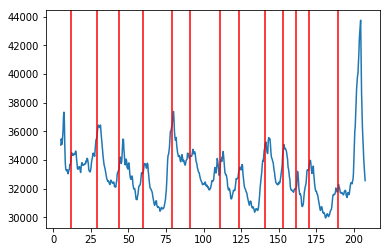

In [30]:
make_peak_plot(X, Y, n=3)